## Practice with MNIST

In [1]:
import torch
import torchvision

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape

torch.Size([1000, 1, 28, 28])

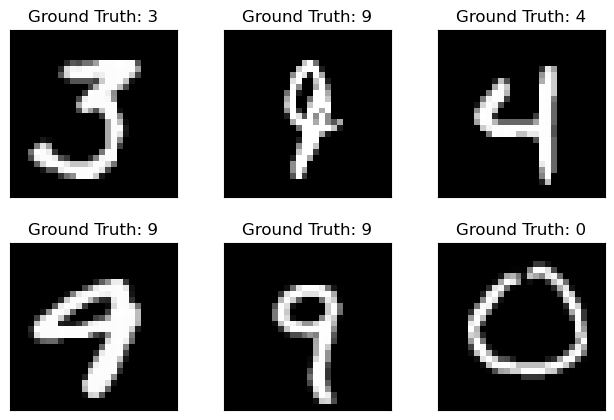

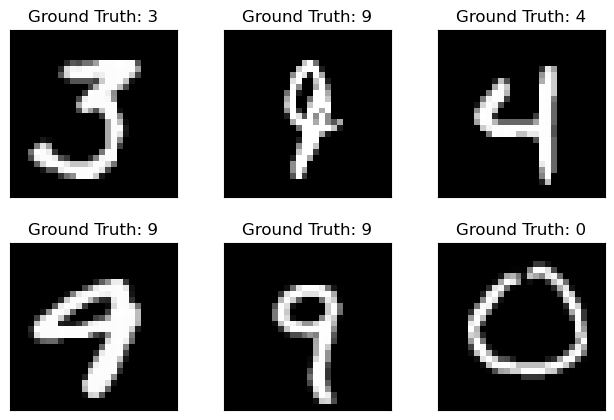

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
# Define the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
# Instantiate the network and optimizer
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

# Print the network architecture
print(network)
for param in network.parameters():
    print(param.shape)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
torch.Size([10, 1, 5, 5])
torch.Size([10])
torch.Size([20, 10, 5, 5])
torch.Size([20])
torch.Size([50, 320])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [10]:
# Track the progress of the training
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    print(data.shape)
    print(target.shape)
    print(output.shape)
    # Compute negative log likelihood loss
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      # save the internal states
      torch.save(network.state_dict(), 'results/mnist/model.pth')
      torch.save(optimizer.state_dict(), 'results/mnist/optimizer.pth')

In [12]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      # Sum up batch loss
      test_loss += F.nll_loss(output, target, size_average=False).item()
      # Get prediction
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [13]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/var/folders/cx/l3gnx5dn4gs_zc1wtxc7xyf40000gn/T/ipykernel_19154/4111780923.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325928
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.287777
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64,

In [14]:
print(test_counter)
print(len(test_losses))

[0, 60000, 120000, 180000]
4


/var/folders/cx/l3gnx5dn4gs_zc1wtxc7xyf40000gn/T/ipykernel_19154/2593714634.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


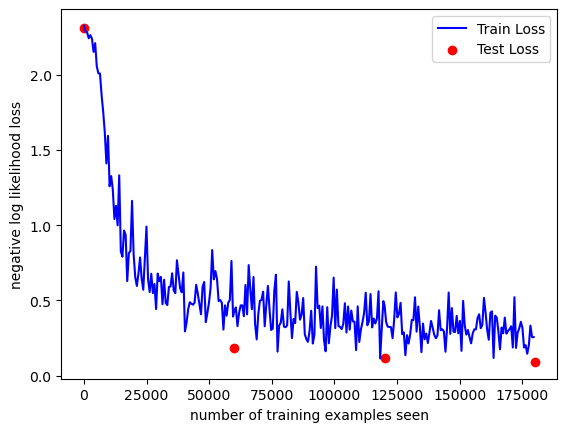

In [15]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig.show()

In [16]:
with torch.no_grad():
  output = network(example_data)

/var/folders/cx/l3gnx5dn4gs_zc1wtxc7xyf40000gn/T/ipykernel_19154/4111780923.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


/var/folders/cx/l3gnx5dn4gs_zc1wtxc7xyf40000gn/T/ipykernel_19154/3857599114.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


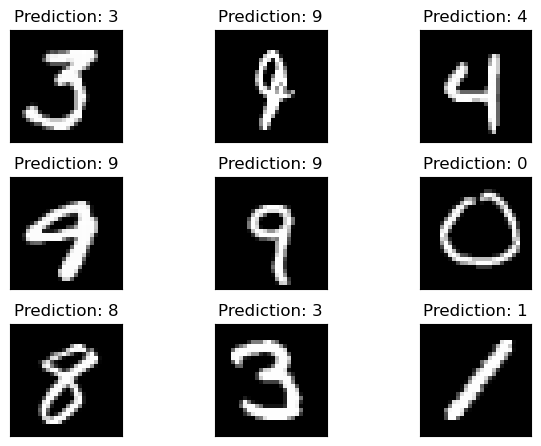

In [22]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig.show()

In [18]:
# Continue training
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [19]:
network_state_dict = torch.load(f='results/mnist/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load(f='results/mnist/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [20]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

/var/folders/cx/l3gnx5dn4gs_zc1wtxc7xyf40000gn/T/ipykernel_19154/4111780923.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.347035
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.296893
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
torch

/var/folders/cx/l3gnx5dn4gs_zc1wtxc7xyf40000gn/T/ipykernel_19154/2593714634.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


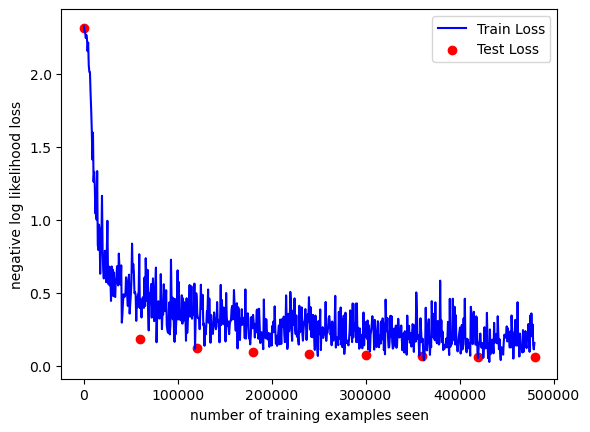

In [21]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig.show()